In [4]:
# Importing necessary libraries
import cv2

import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

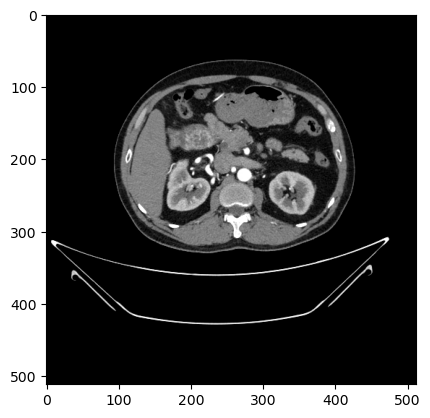

In [6]:
# Plotting the images
orig_img = cv2.imread("CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (10).jpg",1) # 1 indicates color image
# OpenCV uses BGR while Matplotlib uses RGB format

plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.show()


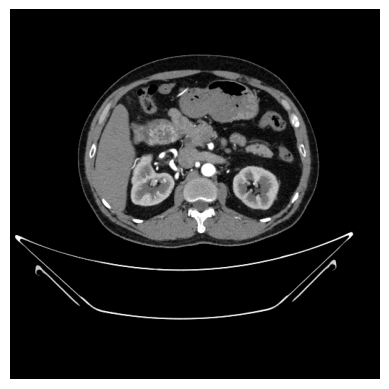

In [7]:
##Converting the image into Grayscale
gray_img = cv2.cvtColor( orig_img, cv2.COLOR_BGR2GRAY ) 
plt.imshow(gray_img,cmap='gray')
plt.axis('off')
plt.show()

Threshold limit: 68.0


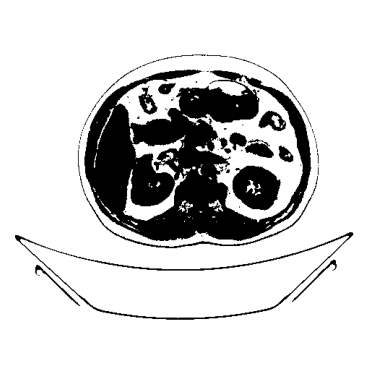

In [8]:
#Performing Otsu's Binarization
#In Otsu's Binarization what happens is that if the pixel value exceeds the threshold value it would be considered as 1, else 0.

ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print("Threshold limit: " + str(ret))

plt.axis('off')
plt.imshow(thresh, cmap = 'gray')

In [9]:
#Specifying the Background and Foreground after Noise Removal

In [10]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

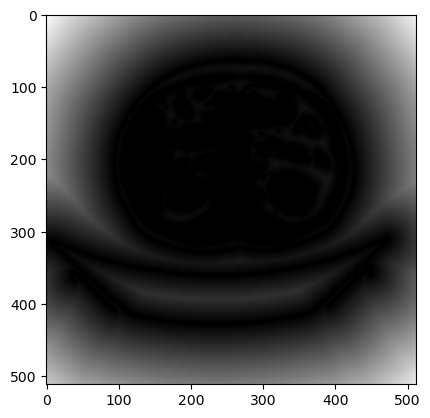

In [11]:
##Performing Distance Transform
##In Distance Tranform what happens is that the gray level intensities of the points
##inside the foreground are changed to distance their respective distances from the closest 0 value


plt.imshow(dist_transform, cmap = 'gray')


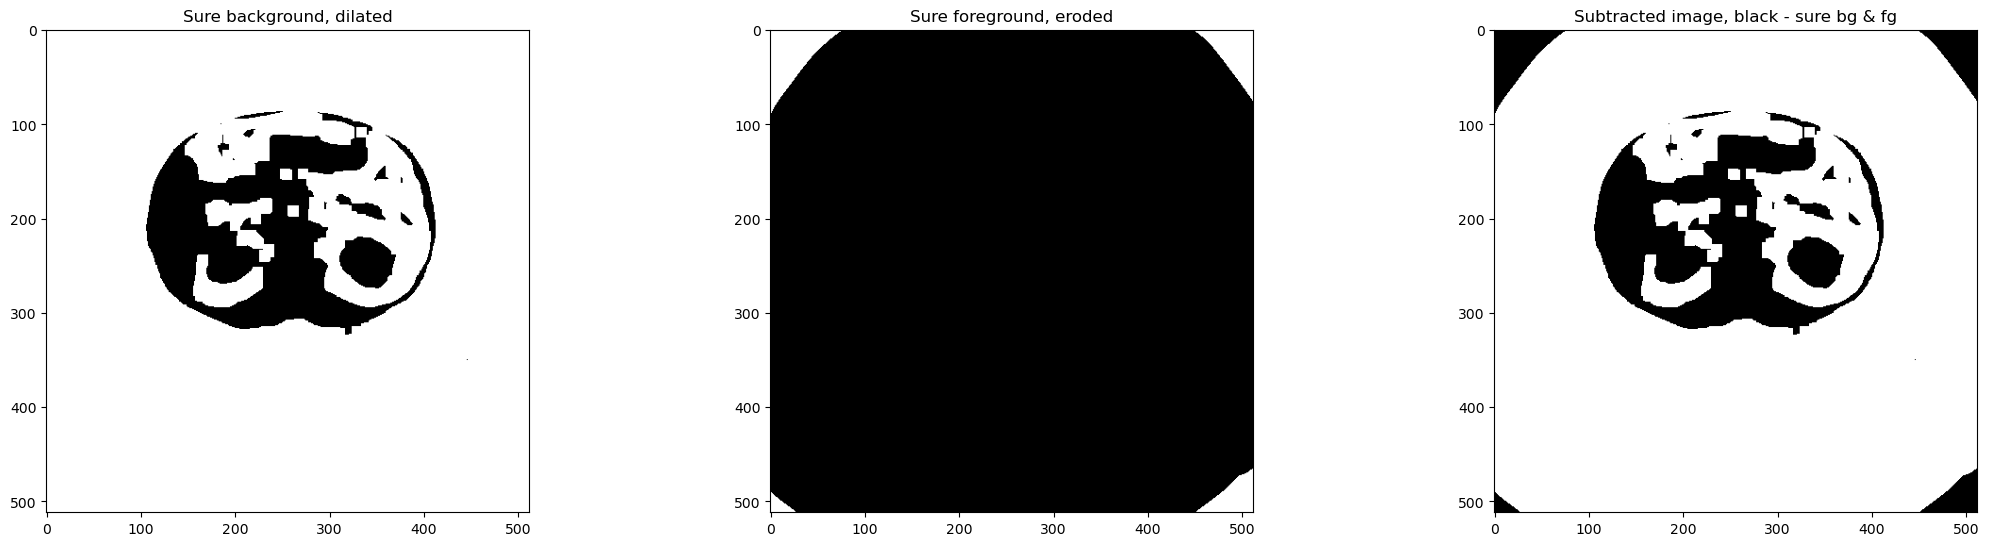

In [13]:
#Plotting the Foreground, background and the Subtracted Image


fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(131)
plt.imshow(sure_bg, cmap = 'gray')
plt.title('Sure background, dilated')

plt.subplot(132)
plt.imshow(sure_fg, cmap = 'gray')
plt.title('Sure foreground, eroded')

plt.subplot(133)
plt.imshow(unknown, cmap = 'gray')
plt.title('Subtracted image, black - sure bg & fg')
plt.tight_layout()

plt.subplots_adjust(wspace = 0.5)
# fine tuning 

In [14]:
##The background is denoted in the black color.
##The second image is the distance transformed and thresholded.
##The white area is the unknown area.

In [15]:
## Displaying the connected components sure_bg and sure_fg

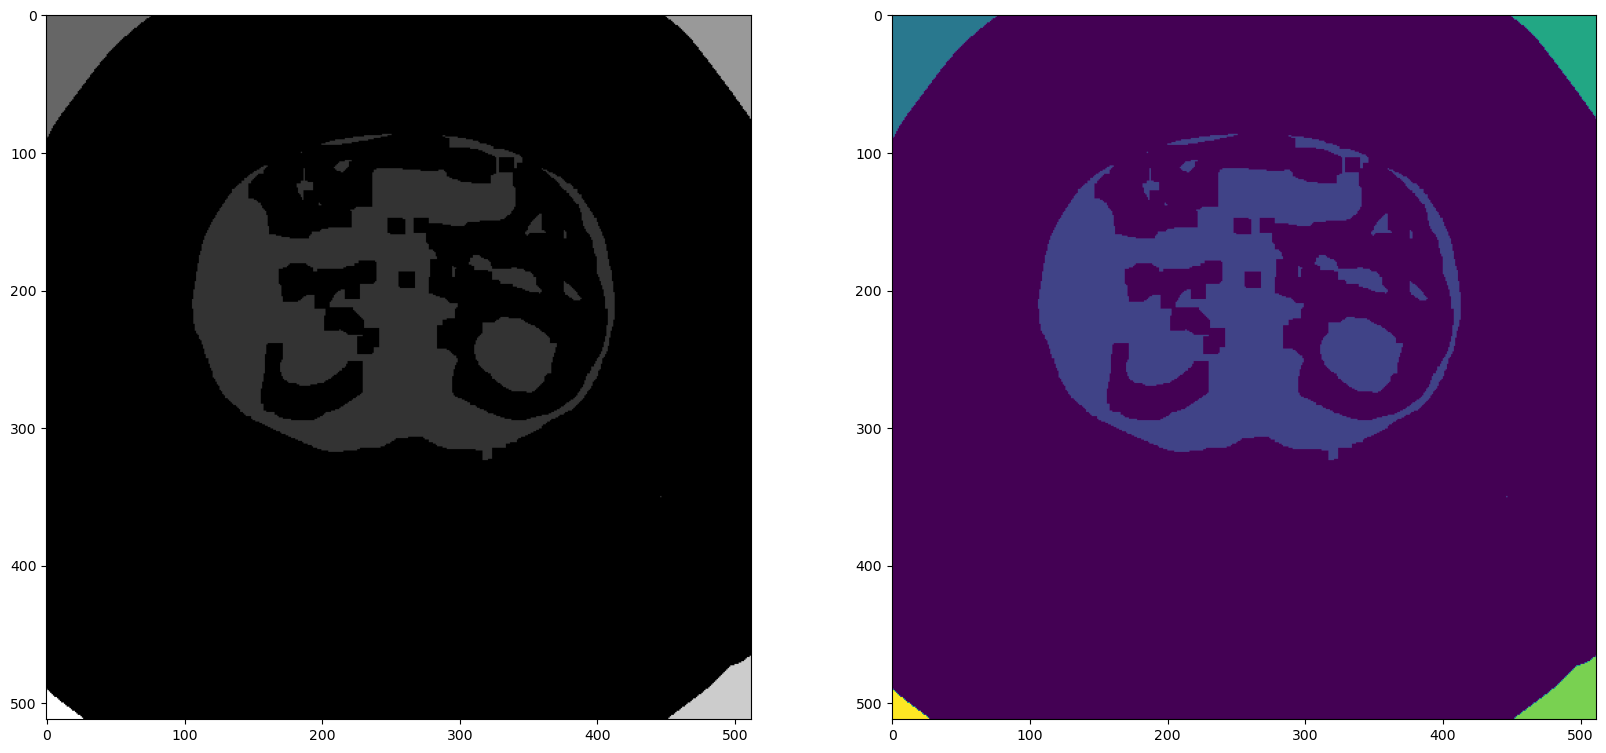

In [16]:
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0

fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(121)
plt.imshow(markers, cmap = 'gray')
plt.subplot(122)
plt.imshow(markers)

In [17]:
##Applying Watershed Segmentation
##In Watershed Segmentation what we do is that we separate different objects in an image.
##It's a region-based technique that uses image morphology.

In [18]:
markers = cv2.watershed(orig_img, markers)
orig_img[markers == -1] = [0, 255,0]

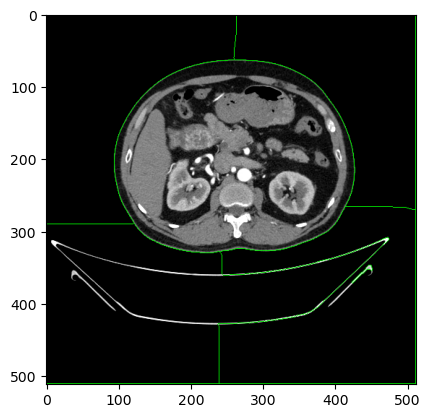

In [19]:
plt.imshow(orig_img)


In [21]:
##Classification using a modified version of Alexnet

In [22]:
# Installing necessary modules
!pip install split-folders

In [26]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings("ignore")

In [24]:
!pip install --upgrade h5py


  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/b5/f4/6047304e24c8ea459d8072c30ebc07e45081114f2f6c27b580e02854fd3a/h5py-3.10.0-cp38-cp38-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.7 MB 1.1 MB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.7 MB 1.5 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.7 MB 2.6 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.7 MB 2.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.7 MB 3.0 MB/s eta 0:00:01
   ----------------- ---------------------- 1.2/2.7 MB 3.7 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.7 MB 3.7 MB/s eta 0:00:01
   ---------------------- ----------------- 1.5/2.7 MB 3.8 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 M

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\SRIVATSAL NARAYAN\\anaconda3\\envs\\myenv\\Lib\\site-packages\\h5py\\hdf5.dll'
Consider using the `--user` option or check the permissions.



In [25]:
!pip install --user --upgrade h5py


  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/b5/f4/6047304e24c8ea459d8072c30ebc07e45081114f2f6c27b580e02854fd3a/h5py-3.10.0-cp38-cp38-win_amd64.whl.metadata
  Using cached h5py-3.10.0-cp38-cp38-win_amd64.whl.metadata (2.5 kB)
Using cached h5py-3.10.0-cp38-cp38-win_amd64.whl (2.7 MB)


In [28]:
train_ds = tf.keras.utils.image_dataset_from_directory("CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",    
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=64,
    image_size=(227, 227),
    shuffle=True,
    seed=42,                                                   
    validation_split=0.2,
    subset="training",                                                  
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
 )

Found 12446 files belonging to 4 classes.
Using 9957 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory("CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
  validation_split=0.2,
  subset="validation",                                                   
  seed=42,
  image_size=(227, 227),
  batch_size=64)

Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['Cyst', 'Normal', 'Stone', 'Tumor']


In [32]:
##Preview

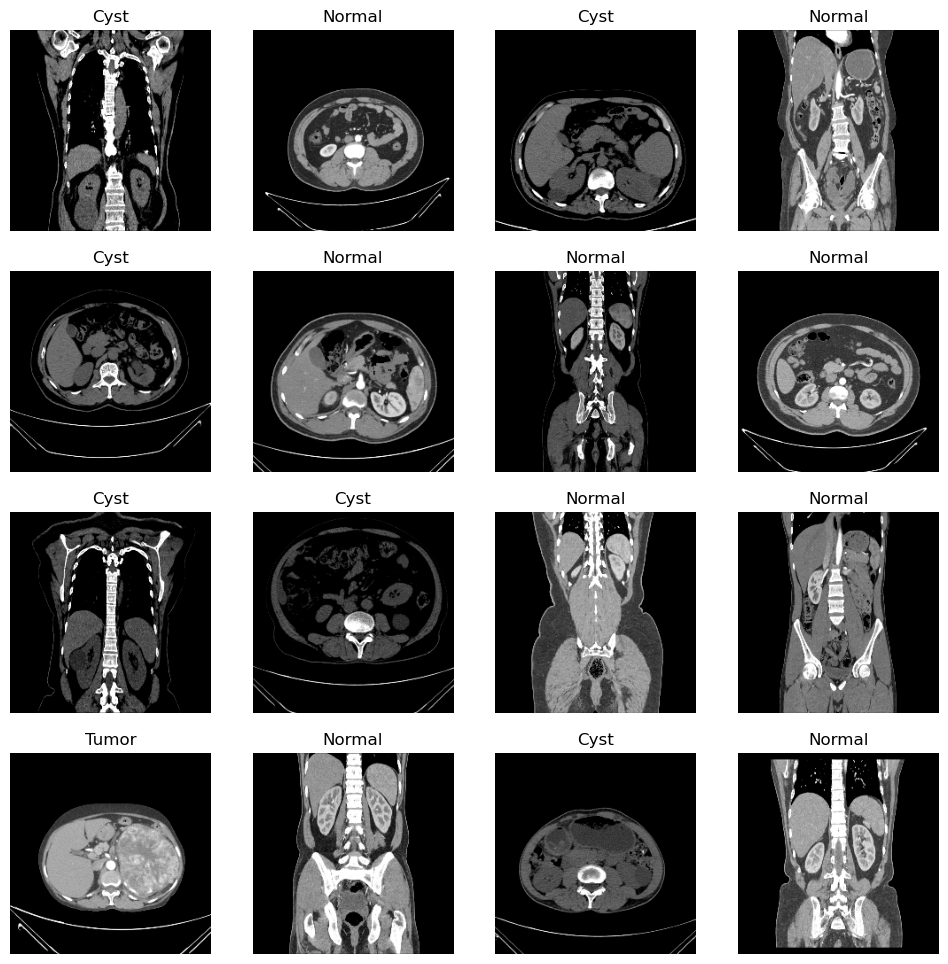

In [33]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 227, 227, 3)
(64,)


In [35]:
#Normalization

In [36]:

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [37]:
##Configuring the data for better performance


In [38]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
#Building the modified Alexnet CNN Model

In [40]:
output_class_units = 4
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (7,7),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (5,5),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [44]:
learning_rate = 0.0001 # Learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [46]:
epochs= 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs,
   ) 

156/156 [==============================] - 5265s 34s/step - loss: 2.0035 - accuracy: 0.6799 - val_loss: 1.1331 - val_accuracy: 0.7569


In [47]:
model.evaluate(val_ds)


39/39 [==============================] - 130s 3s/step - loss: 1.1331 - accuracy: 0.7569


[1.1330615282058716, 0.7569304704666138]